## Lab: Build Advanced Transformers


<a href="https://www.coursera.org/learn/building-deep-learning-models-with-tensorflow/ungradedLti/yIfmt/lab-building-advanced-transformers" target="_parent" style="display: flex; align-items: center; height: 100%;"><img src="https://raw.githubusercontent.com/jimmy-pink/colab-playground/refs/heads/main/resources/icon/coursera.svg" alt="Open In Coursera" style="height: 100%; object-fit: contain;"><span style="height: 100%; display: flex; align-items: center; padding-left: 10px;">Building Advanced Transformers</span></a>

In [ ]:
%pip install tensorflow pyarrow 
%pip install pandas  
%pip install scikit-learn 
%pip install matplotlib 
%pip install requests

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import requests
from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

### 准备数据

In [4]:
import numpy as np
import pandas as pd

# Create a synthetic stock price dataset
np.random.seed(42)
data_length = 2000  # Adjust data length as needed
trend = np.linspace(100, 200, data_length)
noise = np.random.normal(0, 2, data_length)
synthetic_data = trend + noise

# Create a DataFrame and save as 'stock_prices.csv'
data = pd.DataFrame(synthetic_data, columns=['Close'])
data.to_csv('stock_prices.csv', index=False)
data.head(5)

,Close
0,100.993428
1,99.773496
2,101.395427
3,103.196135
4,99.731793
5,99.781851
6,103.458576
7,101.885045
8,99.461251


In [8]:
data = pd.read_csv('stock_prices.csv') 
data = data[['Close']].values 

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Prepare the data for training
def create_dataset(data, time_step=1):
    X, Y = [], []

    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X, Y = create_dataset(data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape) 

Shape of X: (1899, 100, 1)
Shape of Y: (1899,)


### 定义Transformer关键组件

- 定义自注意力

In [22]:
class MultiHeadSelfAttention(Layer): 

    def __init__(self, embed_dim, num_heads=8): 
        super(MultiHeadSelfAttention, self).__init__() 
        self.embed_dim = embed_dim 
        self.num_heads = num_heads 
        self.projection_dim = embed_dim // num_heads 
        self.query_dense = Dense(embed_dim) 
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim) 
        self.combine_heads = Dense(embed_dim) 


    def attention(self, query, key, value): 
        score = tf.matmul(query, key, transpose_b=True) 
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) 
        scaled_score = score / tf.math.sqrt(dim_key) 
        weights = tf.nn.softmax(scaled_score, axis=-1) 
        output = tf.matmul(weights, value) 
        return output, weights 

    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) 

    def call(self, inputs): 
        batch_size = tf.shape(inputs)[0] 
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs) 
        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 
        attention, _ = self.attention(query, key, value) 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim)) 
        output = self.combine_heads(concat_attention) 
        return output 

#### Encoder层 Decoder层  
- TransformerEncoder :  N × TransformerBlocks
    - **EncoderLayer**： 每个Encoder和Decoder都有N个层，这个层就叫TransformerBlock。 
        - EncoderLayer里面理论上需要对Multi-head attention， add&Norm， feedforward 一一实现
            - MultiHeadSelfAttention 自注意力的实现
            - ADD： 残差连接 `self.layernorm1(inputs + attn_output)`
            - Norm: 归一化 `LayerNormalization(epsilon=1e-6)`
            - FeedForward: FNN 
        - 每个Encoder层或Decoder又是由n个TransformerBlock组成


In [17]:
class EncoderLayer(Layer): 

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(EncoderLayer, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 
        
        # Norm： 归一化
        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 

 

    def call(self, inputs, training): 
        # 自注意力
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        
        # ADD： 残差连接1
        out1 = self.layernorm1(inputs + attn_output)  
        
        # Feedforward network： 前馈NN
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        
        # ADD： 残差连接2
        return self.layernorm2(out1 + ffn_output) 


In [18]:
class TransformerEncoder(Layer): 
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerEncoder, self).__init__() 
        self.num_layers = num_layers 
        self.embed_dim = embed_dim 
        self.enc_layers = [EncoderLayer(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)] 
        self.dropout = Dropout(rate) 

    def call(self, inputs, training=False): 
        x = inputs 
        for i in range(self.num_layers): 
            x = self.enc_layers[i](x, training=training) 
        return x 

# Example usage 
embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 
inputs = tf.random.uniform((1, 100, embed_dim)) 
outputs = transformer_encoder(inputs, training=False)  # Use keyword argument for 'training' 
print(outputs.shape)  # Should print (1, 100, 128) 

(1, 100, 128)


### 建模

In [19]:
# Define the necessary parameters 
embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

# Define the Transformer Encoder 
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 

# Build the model 
input_shape = (X.shape[1], X.shape[2]) 
inputs = tf.keras.Input(shape=input_shape) 

# Project the inputs to the embed_dim 
x = tf.keras.layers.Dense(embed_dim)(inputs) 
encoder_outputs = transformer_encoder(x) 
flatten = tf.keras.layers.Flatten()(encoder_outputs) 
outputs = tf.keras.layers.Dense(1)(flatten) 
model = tf.keras.Model(inputs, outputs) 

# Compile the model 
model.compile(optimizer='adam', loss='mse') 

# Summary of the model 
model.summary() 

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 100, 128)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 100, 128)       │       793,088 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.fit(X, Y, epochs=20, batch_size=32)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - loss: 11.8575
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - loss: 0.2037
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - loss: 0.2100
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - loss: 0.1301
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 204ms/step - loss: 0.1438
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - loss: 0.1213
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - loss: 0.1388
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 198ms/step - loss: 0.1402
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 216ms/step - loss: 0.1100
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - loss: 0.1000
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 0.0944
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - loss: 0.0716
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 217ms/step - loss: 0.0748
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 220ms/step - loss: 0.0621
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s

### 模型评估

60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step


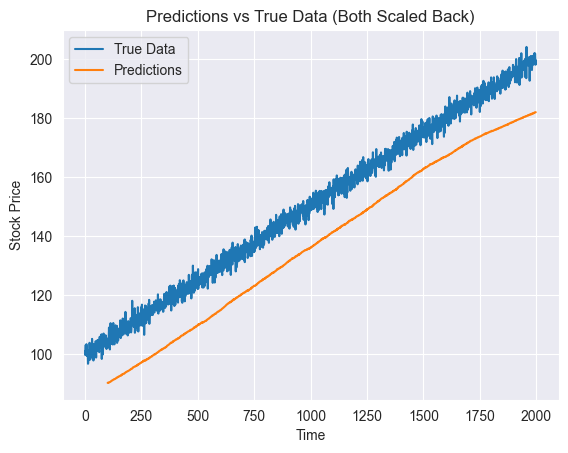

In [21]:
predictions = model.predict(X) 
predictions = scaler.inverse_transform(predictions) 

# Prepare true values for comparison
true_values = scaler.inverse_transform(data.reshape(-1, 1))

# Plot the predictions vs true values
import matplotlib.pyplot as plt 

plt.plot(true_values, label='True Data') 
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.title('Predictions vs True Data (Both Scaled Back)')
plt.show() 